# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [1]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import numpy as np

In [3]:
# Reading files
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
df.sort_values('Date',inplace=True) # sorting by date - not required
df['Date'] = pd.to_datetime(df['Date']).astype('datetime64[ns]') # changing the data type for date column to datetime64[ns]

#Defining a function to remove leap year
def leap_year(s):
    if s.day == 29 and s.month == 2:
        return np.NaN
    else:
        return s
    

df['Date'] = df['Date'].apply(lambda x:leap_year(x)) # changing date of leap year to NaN
df.dropna(inplace=True) # removing leap year
df['month_day'] = df['Date'].apply(lambda x: x.strftime('%m.%d')) # defining a new column to help categorizing
df['month_day'] = df['month_day'].astype('float')
df['month_day'] += df['month_day']%1/0.44

#Splitting data to TMIN and TMAX and according to date
df2014_tmin = df[(df['Date'] < '2014-12-31') & (df['Element'] == 'TMIN')][['month_day','Data_Value']]
df2014_tmax = df[(df['Date'] < '2014-12-31') & (df['Element'] == 'TMAX')][['month_day','Data_Value']]
df2015_tmax = df[(df['Date'] > '2014-12-31') & (df['Element'] == 'TMAX')][['month_day','Data_Value']]
df2015_tmin = df[(df['Date'] > '2014-12-31') & (df['Element'] == 'TMIN')][['month_day','Data_Value']]

#Grouping data for each day and taking maximum value for TMAX and Minimum value for TMIN
df2014_tmin = df2014_tmin.groupby('month_day').min()
df2014_tmax = df2014_tmax.groupby('month_day').max()

df2015_tmin = df2015_tmin.groupby('month_day').min()
df2015_tmax = df2015_tmax.groupby('month_day').max()

#merging data frame of 2005-2014 and 2015 for each element
diff_tmin = df2014_tmin.merge(df2015_tmin,left_index=True,right_index=True)
diff_tmax = df2014_tmax.merge(df2015_tmax,left_index=True,right_index=True)

#keeping records from 2015 which broke records from 2005-2014
diff_tmin['TMIN broken in 2015'] = np.where(diff_tmin['Data_Value_y'] < diff_tmin['Data_Value_x'],diff_tmin['Data_Value_y'],np.NaN)
diff_tmax['TMAX broken in 2015'] = np.where(diff_tmax['Data_Value_y'] > diff_tmax['Data_Value_x'],diff_tmax['Data_Value_y'],np.NaN)


<IPython.core.display.Javascript object>


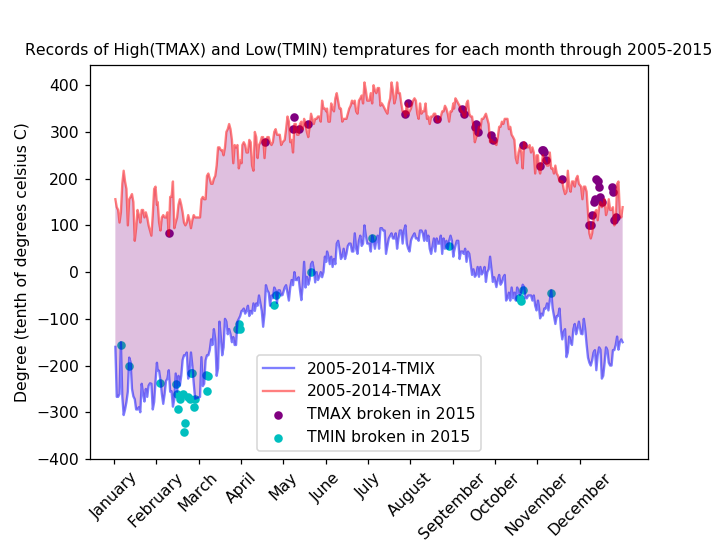

In [4]:
import calendar
labels = []
for i in range(1,13):
    labels.append(calendar.month_name[i])

plt.Figure()
plt.plot(df2014_tmin, '-', label = '2005-2014-TMIX',color = 'b',alpha=0.5)
plt.plot(df2014_tmax, '-', label='2005-2014-TMAX', color = 'r',alpha=0.5)
plt.scatter(diff_tmax.index,diff_tmax['TMAX broken in 2015'],c='purple',s=20)
plt.scatter(diff_tmin.index,diff_tmin['TMIN broken in 2015'],c='c',s=20)
plt.xticks(range(1,13),labels,rotation=45)
plt.gca().fill_between(np.array(df2014_tmin.index,dtype='float'),df2014_tmin['Data_Value'],df2014_tmax['Data_Value'],facecolor ='purple',alpha=0.25)
plt.yticks(np.arange(-400, 500, 100))

#plt.xlabel('Months')
plt.ylabel('Degree (tenth of degrees celsius C)')
plt.title('Records of High(TMAX) and Low(TMIN) tempratures for each month through 2005-2015',fontsize='medium')
plt.legend()
plt.subplots_adjust(bottom=0.15)

<IPython.core.display.Javascript object>


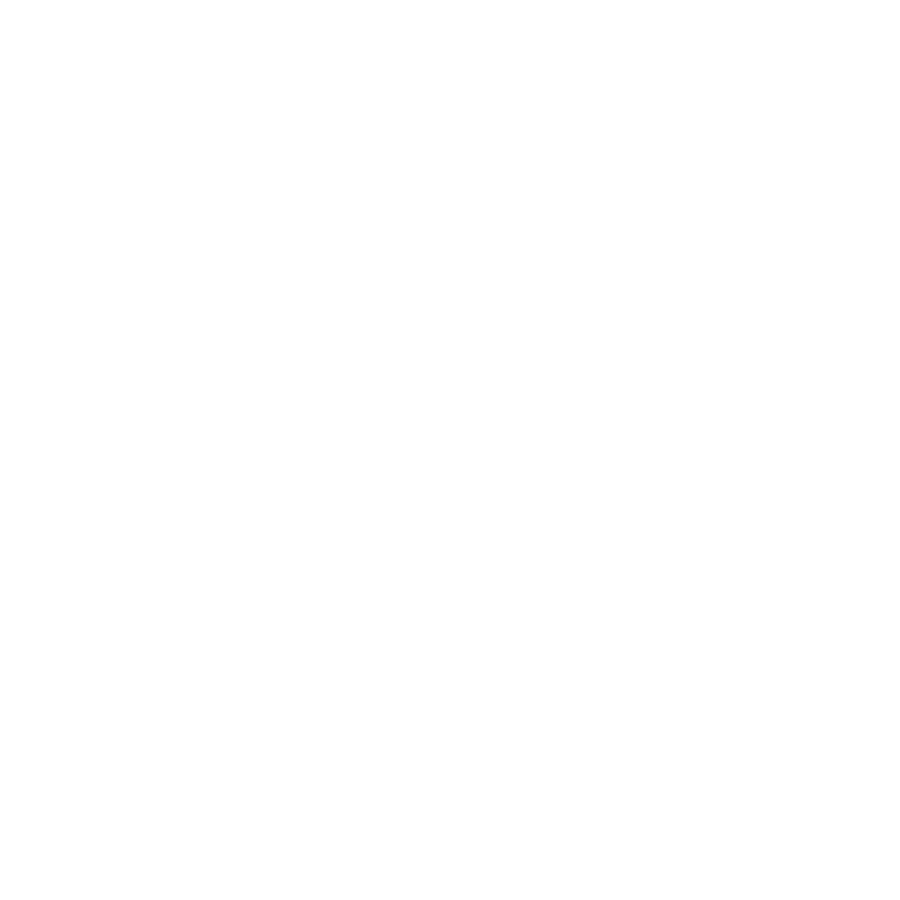

In [5]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')